In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence

The MultiHeadAttention code initializes the module with input parameters and linear transformation layers. It calculates attention scores, reshapes the input tensor into multiple heads, and combines the attention outputs from all heads. The forward method computes the multi-head self-attention, allowing the model to focus on some different aspects of the input sequence.

In [2]:
# code hint
# input to multihead attention will be a 32x10x512 from which key,query and value vectors are generated 
# as above and finally produces a 32x10x512 output.

# https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch
# https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb


In [51]:
def split_heads(x):
        batch_size, seq_length, d_model = x.size()
        return x.view(32, 10, 8, 1024//8 ).transpose(1,2)

In [69]:
X=torch.randint(1, 5000, (32, 10, 512), dtype=torch.float)
X.shape

torch.Size([32, 10, 512])

In [73]:
W_q = nn.Linear(512, 512*2)
W_q

Linear(in_features=512, out_features=1024, bias=True)

In [75]:
Q_intermediate = W_q(X)
Q_intermediate.shape

torch.Size([32, 10, 1024])

In [56]:
Q_intermediate.size(-1)

1024

In [76]:
split_heads(Q_intermediate).shape

torch.Size([32, 8, 10, 128])

In [57]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, num_heads, Q_K_V_projection):
        super().__init__();
        assert d_model%num_heads==0, "d_model number must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        Q_K_V_input_features = d_model
        # Q_K_V_projection
        Q_k_V_output_features = d_model*(Q_K_V_projection)

        self.W_q = nn.Linear(Q_K_V_input_features, Q_k_V_output_features)
        self.W_k = nn.Linear(Q_K_V_input_features, Q_k_V_output_features)
        self.W_v = nn.Linear(Q_K_V_input_features, Q_k_V_output_features)
        self.W_o = nn.Linear(Q_k_V_output_features,Q_K_V_input_features)

        self.d_k = Q_k_V_output_features // num_heads

        ### VERY VERY VERY VERY IMPORTANT to understand the maths behind nn.Linear ###
        ### nn.Linear(m,n)
        # here m is the dimension of the input and n is the dimension of the output of this layer
        # Let our input data to hidden layer 1 has shape 100,4 where 100 are rows and 4 are columns
        # Now, hidden layer 1 is defined as nn.Linear(4,10) where 10 are number of neurons in hidden layer 1 and is the output of this layer
        # In the backend, it has shape like 10,4 -> 10 neurons and each neuron has 4 weights
        # Now, in torch, z= x.W(T) + b ; W(T) means transpose of W
        # now, x is 100,4 and w is 10,4 so W(T) is 4,10, so z = 100,10, and we can see 10 is the output size 
        # meaning each neuron has 100 weights and there are total 10 such neurons
        
    def scaled_dot_product_attention(self,Q,K,V,mask=0):
        self.attn_scores = torch.matmul(Q,K.transpose(-2,-1))/math.sqrt(self.d_k)
        if mask is not None:
            self.attn_scores = self.attn_scores.masked_fill(mask==0, -1e9)
        self.attn_probs=torch.softmax(self.attn_scores, dim=-1)
        self.output_scaled_prod=torch.matmul(self.attn_probs,V)
        return self.output_scaled_prod
    
    def split_heads(self,x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads,self.d_k ).transpose(1,2)
    
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k=x.size()
        return x.transpose(1,2).contiguous().view(batch_size, seq_length, self.d_model)
    
    def forward(self, X,mask=None):
         ############### Very IMPORTANT ###############
         # This means Q*W_q^T to get the desired output i.e passing Q through the linear layer of W_q
         # Actually, when we initialize a linear layer in torch of shape x,y, it creates a weight matrix of shape y,x
         # x,y represents x as input features and y as output featured of that linear layer
         # we create linear layer as nn.Linear(x,y) but it creates a weight matrix of y,x
         # So, therefore, W_q(Q) means Q*W_q^T
         # in our case, Q = X = 10,512 (this means 10 words of 512 embedding of each) and W_q has shape of 1024,512 (although declared as nn.Linear(512,1024))
         # W_q^T = 512,1024
         # Hence,10,512 * (512,1024) = 10,1024
        self.Q= self.split_heads(self.W_q(X))
        self.K= self.split_heads(self.W_k(X))
        self.V= self.split_heads(self.W_v(X))
        
        self.attn_output= self.scaled_dot_product_attention(self.Q,self.K,self.V,mask)
        self.output_forward = self.W_o(self.combine_heads(self.attn_output)) ## Concat (using combine_heads) function + Single Dense Layer
        return self.output_forward
        

In [58]:
# let's decrypt the above class:

### STEP 0: Create the input data and Single Dense Layer

In [59]:
mult_head = MultiheadAttention(512,8,2)
# 512 is size of the embedding of each word or d_model
# 8 is number of heads or num_heads

In [60]:
mult_head.d_k

128

In [61]:
mult_head.W_q
# This is a linear Layer(NN) with input and output as 512-512
# This gets dot product with the actual Q / K / V respectively to form the  real Q / K / V which are then processed with matmul - normalisation and matmul
# The purpose of W_q, Q_k, and W_v is to make these Q, K, V  (embeddings) trainaable and make these embeddings better

Linear(in_features=512, out_features=1024, bias=True)

In [62]:
X=torch.randint(1, 5000, (32, 10, 512), dtype=torch.float) # This is our input
# 32 is batch size
# 10 is number of words in a sentence
# 512 is embedding size

In [63]:
X[0][0].shape, X[0].shape, X.shape

(torch.Size([512]), torch.Size([10, 512]), torch.Size([32, 10, 512]))

In [64]:
X[0][0][0:10]
# 1st 10 values (out of 512) of the 1st word in the 1st batch

tensor([1306., 1090.,  523., 1708., 4734., 1645., 4892., 3238., 1246.,  109.])

In [65]:
# X.view(32,10,8,64)
# This method is used to reshape a tensor

In [66]:
mult_head.W_q(X).shape
# This is dot product of input X and Linear Layer W_q will generate Q
# Similarly for K and V

# W_q = 512*512
# X= 10*512

# Q = X*W_q=  (10*512) * (512*512) = (10*512)
# and 32 means we have 32 such sentences with 10 words in each sentence and each word has 512 embedding size
# So, 32 is batch size

torch.Size([32, 10, 1024])

In [67]:
X=torch.randint(1, 5000, (32, 10, 512), dtype=torch.float) 

Q= mult_head.split_heads(mult_head.W_q(X)) 
K= mult_head.split_heads(mult_head.W_k(X)) 
V= mult_head.split_heads(mult_head.W_v(X)) 

In [68]:
Q.shape

torch.Size([32, 8, 10, 128])

In [78]:
Q[:,:1,:,].shape

torch.Size([32, 1, 10, 128])

In [80]:
Q[:,:2,:,].shape

torch.Size([32, 2, 10, 128])

In [84]:
# Q.K

# or 

# for head in range(1,8):
#     print(Q[: , head-1:head , : , :])

#     torch.matmul(Q[: , head-1:head , : , :], K[: , head-1:head , : , :].transpose())

### STEP1: split_heads
**This is the first step in forward pass of multi-head attentions**

In [85]:

mult_head.split_heads(mult_head.W_q(X)).shape

# Now, 
# here 32 is batch batch size 
# 10 is length of each sentence
# 8*64 = 512. What does this mean ? 
# Answer: we had one head and now we have split that big head into 8 heads. i.e. in multihead we don't create h heads but we split our head.
# That is why we always make sure that embedding size should get divisible by number of heads
# This is what multi-head attention means. Meaning a sentence is broken into multiple parts (multiple heads) and then dot product is done
# to capture attention among the words of that sentence 

torch.Size([32, 8, 10, 128])

In [86]:
# Now let's deep dive into this split head methd:
batch_size, seq_length, d_model = mult_head.W_q(X).size()
print(batch_size, "-", seq_length,"-",d_model)
# Now, this gives batch size, seq_length and embedding dimension (from left to right)

32 - 10 - 1024


In [89]:
# Now, we transform our data i.e. we split this big head into 8 heads with 64 embedding size in each head
print(mult_head.W_q(X).view(batch_size, seq_length, 8,128 ).shape)

# Final output:
# In PyTorch, the transpose(1,2) function returns a tensor that is a transposed version of the 
# input tensor. The dimensions at indices 1 and 2 are swapped
mult_head.W_q(X).view(batch_size, seq_length, 8,128 ).transpose(1,2).shape
# This means 32 batch size with 8 heads and each head has a sentence of 10 length 
# where embedding of each word is 64

torch.Size([32, 10, 8, 128])


torch.Size([32, 8, 10, 128])

### STEP2: scaled_dot_product_attention
**This is the first step in forward pass of multi-head attentions**

In [18]:
# self.Q= self.split_heads(self.W_q(Q)) #This means Q*W_q to get the desired output i.e passing Q through the linear layer of W_q
# self.K= self.split_heads(self.W_k(K))
# self.V= self.split_heads(self.W_v(V))
        
# self.attn_output= self.scaled_dot_product_attention(self.Q,self.K,self.V,mask)
# self.output_forward = self.W_o(self.combine_heads(self.attn_output)) ## COncat + SIngle Dense Layer
        # return self.output_forward

In [90]:
Q.shape

torch.Size([32, 8, 10, 128])

In [22]:
# def scaled_dot_product_attention(self,Q,K,V,mask=0):
#         self.attn_scores = torch.matmul(Q,K.transpose(-2,-1))/math.sqrt(self.d_k)
#         if mask is not None:
#             self.attn_scores = self.attn_scores.masked_fill(mask==0, -1e9)
#         self.attn_probs=torch.softmax(self.attn_scores, dim=-1)
#         self.output_scaled_prod=torch.matmul(self.attn_probs,V)
#         return self.output_scaled_prod

In [91]:
Q.shape, K.transpose(-2,-1).shape

(torch.Size([32, 8, 10, 128]), torch.Size([32, 8, 128, 10]))

In [ ]:
# Q.K^T
# 6,6



In [92]:
torch.matmul(Q,K.transpose(-2,-1)).shape

torch.Size([32, 8, 10, 10])

In [93]:
d_k = 1024/8

# Q.size(-1) / num_of_heads

In [94]:
# So, attentionscores are:

attn_scores = torch.matmul(Q,K.transpose(-2,-1))/math.sqrt(d_k)
attn_scores.shape

torch.Size([32, 8, 10, 10])

In [95]:
# Now, we need to normalise using softmax
attn_probs=torch.softmax(attn_scores, dim=-1)
attn_probs.shape

torch.Size([32, 8, 10, 10])

In [96]:
print(V.shape)

torch.Size([32, 8, 10, 128])


In [97]:
# Now multiply this by V
output_scaled_prod=torch.matmul(attn_probs,V)
output_scaled_prod.shape

torch.Size([32, 8, 10, 128])

In [31]:
attn_output =output_scaled_prod

### STEP3: combine_heads
** Here, we combine all the 8 heads**

In [32]:
# # Now, we have to combine these 8 heads
# self.output_forward = self.W_o(self.combine_heads(self.attn_output)) ## COncat + SIngle Dense Layer

# def combine_heads(self, x):
#         batch_size, _, seq_length, d_k=x.size()
#         return x.transpose(1,2).contigous().view(batch_size, seq_length, self.d_model)


In [98]:
batch_size, num_of_heads, seq_length, d_k  =output_scaled_prod.size()
print(batch_size,"-", num_of_heads,"-",seq_length,"-",d_k)

32 - 8 - 10 - 128


In [99]:
# The contiguous() function in PyTorch is used to return a tensor that is contiguous in memory. 
# This means that the neighboring elements in the tensor are actually next to each other in memory.
# If a tensor is already in the specified memory format, the contiguous() function will 
# return the self tensor. 
# If not, it makes a copy of the tensor such that the order of its elements in memory 
# is the same as if it had been created from scratch with the same data

output_scaled_prod.transpose(1,2).shape,output_scaled_prod.transpose(1,2).contiguous().shape

(torch.Size([32, 10, 8, 128]), torch.Size([32, 10, 8, 128]))

In [101]:
output_scaled_prod.transpose(1,2).contiguous().view(batch_size,seq_length,1024).shape
# Now, the heads have been combined

torch.Size([32, 10, 1024])

In [102]:
# Now, the last step is to pass this combined data through a linear layer
W_o = nn.Linear(1024, 512)
W_o

Linear(in_features=1024, out_features=512, bias=True)

In [107]:
multi_head_output = W_o(output_scaled_prod.transpose(1,2).contiguous().view(batch_size,seq_length,1024))
multi_head_output.shape
#We can see that output is of same dimension as input

torch.Size([32, 10, 512])

In [105]:
X.shape

torch.Size([32, 10, 512])

In [114]:
add_ = torch.add(multi_head_output, X)

In [115]:
add_.shape

torch.Size([32, 10, 512])

In [116]:
add_normalise = torch.softmax(add_,dim=-1)

In [117]:
add_normalise.shape

torch.Size([32, 10, 512])

In [126]:
z= add_normalise
z.shape

torch.Size([32, 10, 512])

In [123]:
d_model=512

#### Position wise

In [124]:
fc1 = torch.nn.Linear(d_model, 256)
fc2 = torch.nn.Linear(256,d_model)

In [127]:
fc1_o = fc1(z)
fc1_o.shape

torch.Size([32, 10, 256])

In [130]:
fc2_o = fc2(fc1_o)
fc2_o.shape

torch.Size([32, 10, 512])

In [131]:
add_normalise_fc = torch.softmax(torch.add(z,fc2_o), dim=-1)


In [133]:
add_normalise_fc.shape

torch.Size([32, 10, 512])

In [ ]:
# padding 
# truncating 
# # BERT - 512

The PositionWiseFeedForward class extends PyTorch’s nn.Module and implements a position-wise feed-forward network. The class initializes with two linear transformation layers and a ReLU activation function. The forward method applies these transformations and activation function sequentially to compute the output. **This process enables the model to consider the position of input elements while making predictions.**

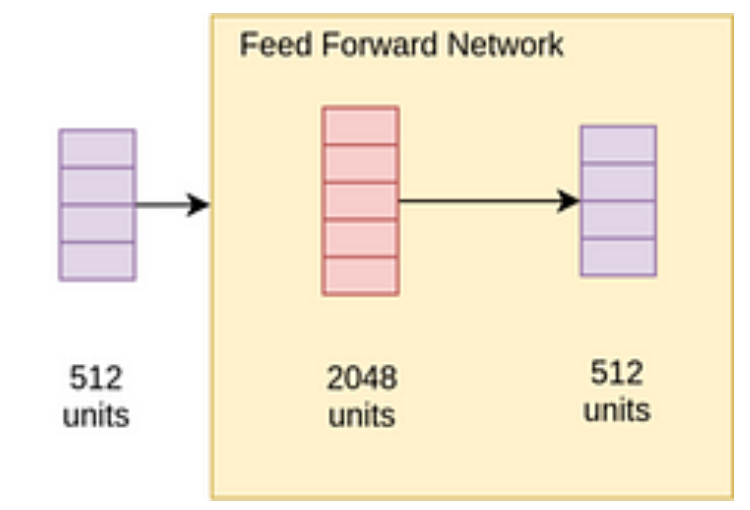

* The feed-forward network applies itself to each position in the output Z parallelly(Each position can be thought of as a word) and hence the name Position-wise feed-forward network. The feed-forward network also shares weight, so that the length of the source sentence doesn’t matter(Also, if it didn’t share weights, we would have to initialize a lot of such networks based on max source sentence length and that is not feasible)
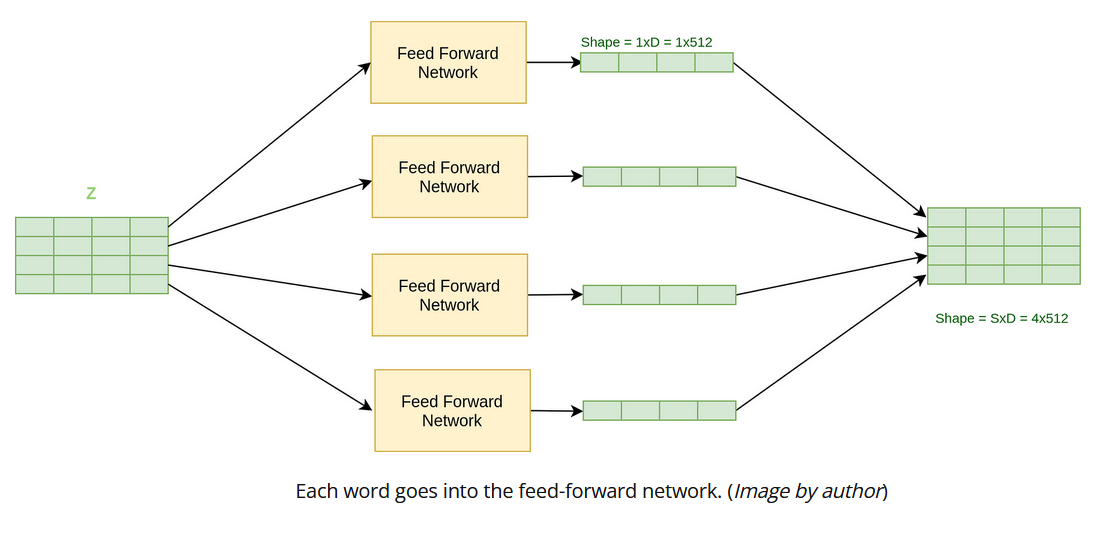

In [40]:

# It is actually just a linear layer that gets applied to each position(or word)
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

The EncoderLayer class initializes with input parameters and components, including a MultiHeadAttention module, a PositionWiseFeedForward module, two layer normalization modules, and a dropout layer. The forward methods computes the encoder layer output by applying self-attention, adding the attention output to the input tensor, and normalizing the result. Then, it computes the position-wise feed-forward output, combines it with the normalized self-attention output, and normalizes the final result before returning the processed tensor

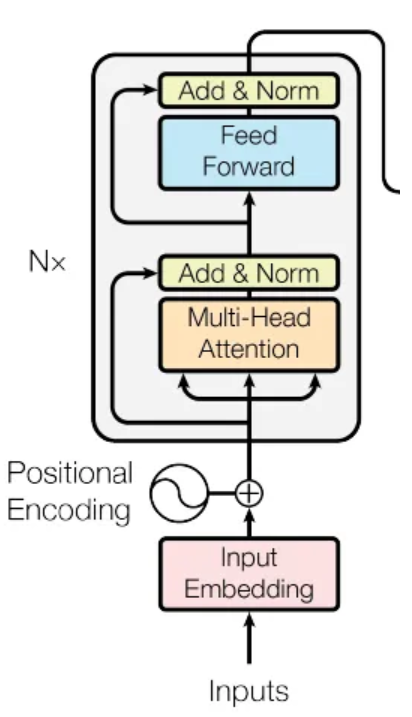

In [42]:
# An Encoder layer consists of a Multi-Head Attention layer, a Position-wise Feed-Forward layer, and two Layer Normalization layers.

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)  #This will call the forward function of this class
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

![0 SPZgT4k8GQi37H__.png](<attachment:0 SPZgT4k8GQi37H__.png>)
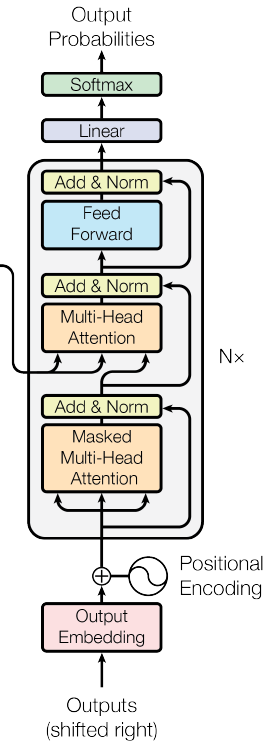

A Decoder layer consists of two Multi-Head Attention layers, a Position-wise Feed-Forward layer, and three Layer Normalization layers.

The DecoderLayer initializes with input parameters and components such as MultiHeadAttention modules for masked self-attention and cross-attention, a PositionWiseFeedForward module, three layer normalization modules, and a dropout layer.

The forward method computes the decoder layer output by performing the following steps:

1. Calculate the masked self-attention output and add it to the input tensor, followed by dropout and layer normalization.
2. Compute the cross-attention output between the decoder and encoder outputs, and add it to the normalized masked self-attention output, followed by dropout and layer normalization.
3. Calculate the position-wise feed-forward output and combine it with the normalized cross-attention output, followed by dropout and layer normalization.
4. Return the processed tensor.

In [43]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask) #enc_output means output of the encoder, x is input of decoder
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

**Positional Encoding is used to inject the position information of each token in the input sequence**. It uses sine and cosine functions of different frequencies to generate the positional encoding

The PositionalEncoding class initializes with input parameters d_model and max_seq_length, creating a tensor to store positional encoding values. The class calculates sine and cosine values for even and odd indices, respectively, based on the scaling factor div_term. The forward method computes the positional encoding by adding the stored positional encoding values to the input tensor, **allowing the model to capture the position information of the input sequence**

In [52]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__();
        
        pe = torch.zeros(max_seq_length,d_model)
        self.position = torch.arange(0,max_seq_length, dtype=torch.float).unsqueeze(1)
        self.div_term = torch.exp(torch.arange(0,d_model, 2).float() * -(math.log(10000.0)/d_model))
        
        pe[:,0::2] = torch.sin(self.position*self.div_term)
        pe[:,1::2] = torch.cos(self.position*self.div_term)
        
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
        
    def forward(self, x):
            return x + self.pe[:, :x.size(1)]

nn.Embedding holds a Tensor of dimension (vocab_size, vector_size), i.e. of the size of the vocabulary x the dimension of each vector embedding, and a method that does the lookup.

When you create an embedding layer, the Tensor is initialised randomly. It is only when you train it when this similarity between similar words should appear. Unless you have overwritten the values of the embedding with a previously trained model, like GloVe or Word2Vec, but that's another story.

In [68]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super().__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model) #How does it create embedding ? See Above
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [69]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

In [70]:
src_data.shape

torch.Size([64, 100])

In [71]:
transformer.encoder_layers

ModuleList(
  (0-5): 6 x EncoderLayer(
    (self_attn): MultiHeadAttention(
      (W_q): Linear(in_features=512, out_features=512, bias=True)
      (W_k): Linear(in_features=512, out_features=512, bias=True)
      (W_v): Linear(in_features=512, out_features=512, bias=True)
      (W_o): Linear(in_features=512, out_features=512, bias=True)
    )
    (feed_forward): PositionWiseFeedForward(
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (relu): ReLU()
    )
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [72]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


In [66]:
# transformer.train()

Transformer(
  (encoder_embedding): Embedding(5000, 512)
  (decoder_embedding): Embedding(5000, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
 

In [74]:
for epoch in range(4):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.680886268615723
Epoch: 2, Loss: 8.553096771240234
Epoch: 3, Loss: 8.481478691101074
Epoch: 4, Loss: 8.432169914245605
